# Практическое задание 3 

# Классификация с использованием BERT  и Transfer learning

## курс "Математические методы анализа текстов"


### ФИО: Бикметов Данил Наильевич

## Введение


В этом задании вы будете определять категории товара по данным из чеков, предоставленным в соревновании [Data Fusion Context](https://boosters.pro/championship/data_fusion/data).


Для этого задания вам понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Transformers](https://github.com/huggingface/transformers).
 - [Tokenizers](https://github.com/huggingface/tokenizers).

Данные лежат в архиве data.zip, в котором лежит файл `data.csv`, содержащий тексты и соответствующие им категории товаров. Все объекты поделены между train, test, val и unsupervised. Для unsupervised объектов категории товаров недоступны. 

Скачать данные можно здесь: [ссылка на google диск](https://drive.google.com/file/d/1AHs7qJYg2tc8zblGlT0Dpe50e6RW-gAW/view?usp=sharing)

In [1]:
import tests

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Часть 1. Подготовка данных (2 балла)

Классические методы NLP (например, как мы делали в первом и втором домашнем задании) преобразуют тексты в списки индексов следующим образом:
1. "Очистка текста" от плохих символов, приводим (или не приводим) текст к нижнему регистру.
2. Текст делится по пробелам на слова.
3. По полученной коллекции текстов строится словарь вида "слово -> индекс", редкие слова выбрасываются, стопслова иногда тоже
4. Побитый на слова текст превращается в список индексов с помощью этого словаря.

Для трансформеров схема выглядит немного по-другому — используются более продвинутые методы токенизации типа `wordpiece, bpe, sentencepiece`. Основное концептуальное отличие — текст делится не только на слова по пробелам, но и сами слова делятся на "подслова" (читай subwords). Это верно для BPE и wordpiece, а sentencepiece вообще не учитывает пробелы. Более подробно ознакомиться с этими методами токенизации можно в наших лекциях.

В данном задании предлагается использовать wordpiece токенизатор, который использовали в оригинальной статье про BERT. Построить его можно с помощью библиотеки `tokenizers`:
1. Считайте данные с помощью `pandas`
2. Используя метод `tokenizers.BertWordPieceTokenizer.train` и список сырых текстов постройте токенизатор. Используйте нижний регистр (lowercase), чистый текст (clean_text), без акцентов (strip_accents), размера словаря 30000 (vocab_size).
3. Сохраните построенный токенизатор (метод `tokenizer.save_model`) и создайте объект класса `transformers.BertTokenizerFast`, который работает быстрее стандартной реализации, но не позволяет её обучать.

**Важно:** нужно при обучении c помощью параметра `special_tokens` завести индексы для токенов `[PAD], [UNK], [CLS], [SEP], [MASK]`, которые понадобятся нам дальше для обучения и использования модели.

In [3]:
import pandas as pd

data = pd.read_csv('task3_data.csv')

In [4]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast

import os, shutil


class WordpieceTokenizer:

    def __init__(
            self, 
            vocab_path, 
            strip_accents=True, 
            clean_text=True, 
            lowercase=True
    ):
        """
            vocab_path: путь к словарю
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            Подгружает токенизатор с помощью BertTokenizerFast.
        """
        self._tokenizer = BertTokenizerFast(
            vocab_file=vocab_path,
            strip_accents=strip_accents,
            clean_text=clean_text,
            do_lower_case=lowercase
        )

    @classmethod
    def from_corpus(
            cls,
            corpus,
            corpus_save_path,
            tokenizer_save_path,
            tokenizer_name,
            vocab_size=30000,
            min_frequency=2,
            strip_accents=True,
            clean_text=True,
            lowercase=True
    ):
        """
            corpus: список текстов
            corpus_save_path: временный путь для сохранения текстов в текстовом файле
            tokenizer_save_path: путь для сохранения файлов токенизатора
            tokenizer_name: название токенизатора, влияет на названия файлов токенизатора
            vocab_size: размер словаря
            min_frequency: минимальная частота элемента в словаре
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            С помощью списка сырых текстов формирует токенизатор
        """
        with open(corpus_save_path, 'w', encoding='utf-8') as f:
            for text in corpus:
                f.write(text + '\n')

        tokenizer = BertWordPieceTokenizer(
            clean_text=clean_text,
            strip_accents=strip_accents,
            lowercase=lowercase,
        )
        tokenizer.train(
            [corpus_save_path],
            vocab_size=vocab_size,
            min_frequency=min_frequency,
            special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
        )

        os.makedirs(tokenizer_save_path, exist_ok=True)
        tokenizer.save_model(tokenizer_save_path)

        os.remove(corpus_save_path)

        return cls(
            vocab_path=os.path.join(tokenizer_save_path, 'vocab.txt'),
            strip_accents=strip_accents,
            clean_text=clean_text,
            lowercase=lowercase
        )


    def __call__(self, text):
        """
            text: str. Сырой текст
            
            returns: list of ints. Список индексов
            
            C помощью метода .encode преобразует текст в индексы.
        """
        return self._tokenizer.encode(text, add_special_tokens=False)

    @property
    def cls_token_id(self):
        """
            returns: индекс CLS токена
        """
        return self._tokenizer.cls_token_id

    @property
    def pad_token_id(self):
        return self._tokenizer.pad_token_id

    @property
    def mask_token_id(self):
        return self._tokenizer.mask_token_id

    @property
    def sep_token_id(self):
        return self._tokenizer.sep_token_id

    @property
    def vocab_size(self):
        """
            returns: размер словаря
        """
        return self._tokenizer.vocab_size

Создайте токенизатор:

In [5]:
corpus = [row for row in data.text]

In [6]:
tokenizer = WordpieceTokenizer.from_corpus(
    corpus=corpus,
    corpus_save_path='./corpus',
    tokenizer_save_path='./tokenizer',
    tokenizer_name='wordpiece'
)

tests.test_tokenizer(tokenizer)




Correct.


Нам доступно довольно большое количество неразмеченных данных, которое можно использовать для предобучения модели. Мы рассмотрим две задачи предобучения:
1. **Masked Language Modeling** — задача из BERT. Выбираем 15% слов, из них 80% заменяем на токен [MASK], 10% меняем на другие случайные слова, 10% оставляем как есть. Эти 15% слов предсказываем моделью. Вспомним пример из оригинальной статьи:
    * Исходный текст: `my dog is hairy`
    * Выбираем случайным образом 15% токенов для задачи. Допустим, выбрали четвертый токен - `hairy`
    * В 80% случаев заменяем токен на `[MASK]`: `my dog is [MASK]`
    * В 10% случаев на другой случайный токен: `my dog is apple`
    * В 10% случаев оставляем неизменным: `my dog is hairy`
    
    
2. **Sentence Order Prediction** — задача из ALBERT. Делим текст на два сегмента, с вероятностью 50% меняет сегменты местами. Предсказываем, в правильном ли порядке находятся сегменты.
    * Текст: `the man went to the store. he bought a gallon of milk`
    * Токенизируем и делим его на два сегмента: `the man went to the store` и `he bought a gallon of milk`
    * C вероятностью 50% меняем их местами: `[CLS] he bought a gallon of milk [SEP] the man went to the store`
    * С вероятностью 50% оставляем на месте: `[CLS] the man went to the store [SEP] he bought a gallon of milk`
    * "Левому" сегменту соответствует нулевой индекс сегмента, "правому" - индекс 1

Большая часть логики предобучения реализуется при подготовке данных.

Реализуйте **PretrainDataset**, который токенизирует поданные сырые тексты и умеет возвращать для текста с конкретным индексом случайный сегмент длины, не большей чем `maxlen`. Логика для задачи **SOP** должна быть реализована в `__getitem__`: выбранный сегмент надо поделить на два равных сегмента, подбросить монетку, и с 50% вероятностью поменять сегменты местами. Нужно также добавить `[CLS]` и `[SEP]` токены.

**hint:** чтобы существенно ускорить обучение (не потеряв при этом в качестве), после токенизации отсортируйте датасет по длине текстов.
**hint:** токенизация датасета для предобучения занимает существенное время (5 минут), поэтому во время отладки стоит сделать её один раз и сохранить результат на диск

In [7]:
import numpy as np
import random

import torch
from torch.utils.data import Dataset
from tqdm import tqdm


class PretrainDataset(Dataset):
    
    def __init__(
            self,
            corpus,
            tokenizer,
            minlen,
            maxlen,
            permute_prob=0.5,
            verbose=False,
            presort=False
    ):
        """
            corpus: list of strings. Список сырых текстов
            tokenizer: токенизатор
            minlen: минимально допустимая длина текста
            permute_prob: вероятность, с которой два сегмента меняются местами (происходит swap)
            maxlen: максимальная длина текста
            verbose: вывод прогресса токенизации текстов с помощью tqdm
            presort: отсортировать датасет по длинам токенизированных текстов (т.е. ds[0] выдает самый короткий текст)
        """
        super().__init__()
        self._corpus = corpus
        self._tokenizer = tokenizer
        self._minlen = minlen
        self._maxlen = maxlen
        self._permute_prob = permute_prob
        self._verbose = verbose
        self._presort = presort

        self._tokenized_data = self.tokenize_corpus()

        if self._presort:
            self._sorted_indices = np.argsort([len(tokens) for tokens in self._tokenized_data])
        else:
            self._sorted_indices = None
        
    def __len__(self):
        return len(self._tokenized_data)
    
    @property
    def tokenizer(self):
        """
            returns: tokenizer. Нужно для тестов
        """
        return self._tokenizer
    
    def set_maxlen(self, maxlen):
        """
            maxlen: максимальная длина текста
            
            поставить новое максимальное значение длины
        """
        self._maxlen = maxlen

    def tokenize_corpus(self):
        tokenized_data = []
        for text in tqdm(self._corpus, desc="Tokenizing", disable=not self._verbose):
            tokens = self._tokenizer(text)
            if len(tokens) >= self._minlen:
                tokenized_data.append(tokens)
        return tokenized_data
        
    def __getitem__(self, idx):
        """
            returns:
                input_ids - тензор с индексами,
                token_type_ids - тензор с сегментными айдишниками (0 у левого сегмента, 1 у правого),
                permuted - был ли swap сегментов
        """
        if self._presort:
            idx = self._sorted_indices[idx]

        tokens = self._tokenized_data[idx]

        if len(tokens) > self._maxlen:
            tokens = tokens[:self._maxlen]

        split_point = random.randint(1, len(tokens) - 1)
        segment1 = tokens[:split_point]
        segment2 = tokens[split_point:]

        permuted = random.random() < self._permute_prob
        if permuted:
            segment1, segment2 = segment2, segment1

        input_ids = [self._tokenizer.cls_token_id] + segment1 + [self._tokenizer.sep_token_id] + segment2 + [self._tokenizer.sep_token_id]
        token_type_ids = [0] * (len(segment1) + 2) + [1] * (len(segment2) + 1)

        return torch.tensor(input_ids), torch.tensor(token_type_ids), permuted

Длину текстов нужно ограничить снизу. Нет смысла рассматривать слишком короткие тексты (например, единичную длину), для которых задачи предобучения вообще не работают. Длинные тексты более эффективны для задач типа MLM, так как у модели больше контекста для предсказания и больше таргетов на один объект.

Разумный способ определить минимальную длину текстов для MLM  — подобрать такую минимальную длину, чтобы вероятность замаскировать хотя бы одно слово в тексте была больше заданного порога.

Т.е. если мы каждое слово маскируем с вероятностью 15%, какой длины должен быть текст, чтобы с вероятностью $\geqslant$ 50% было замаскировано хотя бы одно слово?

Используйте ответ на данный вопрос как минимальную допустимую длину текстов:

In [8]:
import math

def calculate_min_length(p_mask, T):
    return math.ceil(math.log(1 - T) / math.log(1 - p_mask))

p_mask = 0.15  # Вероятность маскировки одного слова
T = 0.5  # Желаемый порог вероятности замаскировать хотя бы одно слово

minlen = calculate_min_length(p_mask, T)
print(f"Минимальная длина текста: {minlen}")

Минимальная длина текста: 5


Создайте датасет (с произвольным разумным значением maxlen):

In [9]:
ds = PretrainDataset(
    corpus=corpus,
    tokenizer=tokenizer,
    minlen=minlen,
    maxlen=100,
    permute_prob=0.5,
    verbose=False,
    presort=True
)

In [10]:
tests.test_dataset(ds)

Correct.


Длину текстов нужно как-то ограничить сверху. Иначе, если встретится какой-то очень-очень длинный текст, он не поместится в видеопамять. Самый простой способ определить ограничение по длине  — после токенизации построить гистограмму длин (например, используя **sns.distplot**) и методом пристального взгляда определить разумное ограничение длины. Другой вариант  — взять большое значение квантили.

**Вопрос:** какая максимальная длина текста подходит для этого датасета?

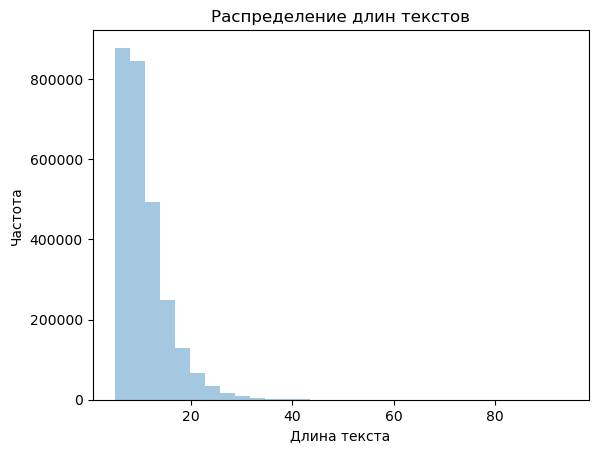

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


text_lengths = [len(tokens) for tokens in ds._tokenized_data]

sns.distplot(text_lengths, kde=False, bins=30)
plt.title("Распределение длин текстов")
plt.xlabel("Длина текста")
plt.ylabel("Частота")
plt.show()

Присвойте максимально допустимое значение длины:

In [12]:
ds.set_maxlen(100)

Если для задачи **SOP** мы готовим данные при индексации датасета `PretrainDataset`, то маскирование для задачи **MLM** удобней делать в Collator'е в тензорном виде.

Как с вероятностью `15%` заменить в тензоре `input_ids` значения на `0`: 

1. `mask = torch.rand(input_ids.shape) < 0.15`
2. `input_ids = torch.where(mask, 0, input_ids)`

Как сгенерировать случайные элементы словаря на каждый элемент батча: `torch.randint_like(input_ids, low=num_special_tokens, high=self._tokenizer.vocab_size)`.

В `Collator` нужно также:
1. сделать паддинг.
2. из (примерно) 15% выбранных токенов 10% поменять на случайные и 10% оставить в исходном виде, остальные замаскировать
3. сформировать таргеты. Нам нужно понимать, какие именно 15% токенов мы выбрали для предсказания + какие были исходные метки для них.

Важно: `[CLS]` и другие специальные токены токены маскировать не надо

In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


class Collator:
    
    def __init__(
            self,
            tokenizer,
            non_target_idx=-100,
            mask_prob=0.15,
            random_prob=0.1,
            keep_unchanged_prob=0.1
    ):
        """
            tokenizer: токенизатор
            non_target_idx: значение для индексов, не использующихся как таргеты. 
                Используйте его, чтобы пометить "не таргет" токены
            mask_prob: вероятность выбрать индекс как таргет
            random_prob: вероятность для уже выбранного индекса поменять его на случайное значение вместо маскирования
            keen_unchanged_prob: вероятность оставить индекс в исходном виде вместо маскирования
        """
        self._tokenizer = tokenizer
        self._non_target_idx = non_target_idx
        self._mask_prob = mask_prob
        self._random_prob = random_prob
        self._keep_unchanged_prob = keep_unchanged_prob
        
    def __call__(self, batch):
        """
            batch: список вида [ds[i] for i in [12, 3, 2, 5]]
            
            returns: 
                input_ids: испорченные входные индексы токенов с замаскированными значениями
                token_type_ids: сегментные эмбеддинги
                labels: истинные значения входных индексов, как таргеты
                permuted: был ли свап сегментов
        """
        input_ids, token_type_ids, permuted = zip(*[(ds[0], ds[1], ds[2]) for ds in batch])

        input_ids = pad_sequence(input_ids, batch_first=True)
        token_type_ids = pad_sequence(token_type_ids, batch_first=True)
        
        permuted = torch.tensor(permuted, dtype=torch.float32).view(-1, 1)  # Преобразуем в тензор и добавим размерность

        labels = input_ids.clone()

        mask = torch.rand(input_ids.shape) < self._mask_prob
        non_target_mask = mask & (input_ids != self._tokenizer.cls_token_id) & (input_ids != self._tokenizer.sep_token_id)
        random_mask = (non_target_mask & (torch.rand(input_ids.shape) < self._random_prob)).bool()

        input_ids[non_target_mask] = self._tokenizer.mask_token_id
        input_ids[random_mask] = torch.randint_like(input_ids[random_mask], low=self._tokenizer.mask_token_id+1, high=self._tokenizer.vocab_size)

        labels[~non_target_mask] = self._non_target_idx

        return input_ids, token_type_ids, labels, permuted

Создайте `collator` и `dataloader`. Для предобучения предлагается использовать большой `batch_size`.

In [30]:
collator = Collator(tokenizer, non_target_idx=-100)

dl = DataLoader(
    ds,
    collate_fn=collator,
    batch_size=256,
    shuffle=False
)

In [31]:
tests.test_collator(ds, collator)

Correct.


## Часть 2. Создание модели (2 балла)

В качестве модели мы будем использовать энкодер трансформера точь-в-точь в таком же виде, как его использовали в оригинальной статье про BERT. 

Прежде чем начать писать составляющие энкодера, обсудим инициализацию весов. Для трансформера нам понадобится большое количество линейных слов (`nn.Linear`), у которых для инициализации по дефолту используется равномерное распределение и отсутствует зануление bias'ов: $$\text{Uniform}\left(-\frac{1}{\sqrt{N_{\text{in\_features}}}}, \frac{1}{\sqrt{N_{\text{in\_features}}}}\right).$$

В оригинальной статье про BERT для весов используется **TruncatedNormal** со стандартным отклонением 0.02, bias'ы инициализируются нулями и модель обучается значительно лучше (это можно в ходе домашнего задания проверить).

Поэтому, после создания линейных слоев и матрицы эмбеддингов, необходимо в явном виде вызывать для них TruncatedNormal инициализацию:

1. `layer = ...`
2. `nn.init.trunc_normal_(layer.weight.data, std=0.02, a=-2 * 0.02, b=2 * 0.02)`.

Для линейных слоев нужно также вызывать `layer.bias.data.zero_()`.


**TruncatedNormal** распределение отличается от нормального тем, что если величины выходят за границы отрезка [a, b], для этих величин повторно происходит сэмплирование до тех пор, пока они не попадут в нужный отрезок. Для BERT stddev = 0.02:

$$[a; b] = [- 2  \cdot \text{stddev}; 2 \cdot \text{stddev}].$$

Напишите функцию для инициализации линейных слоев и матрицы эмбеддингов **TruncatedNormal** распределением:

In [32]:
from torch import nn


def init_layer(layer, initializer_range=0.02, a=-2*0.02, b=2*0.02):
    if isinstance(layer, nn.Linear):
        nn.init.trunc_normal_(layer.weight.data, std=initializer_range, a=a, b=b)
        layer.bias.data.zero_()
    elif isinstance(layer, nn.Embedding):
        nn.init.trunc_normal_(layer.weight.data, std=initializer_range, a=a, b=b)
    else:
        pass

Приступим к созданию энкодера трансформера.

<img src="images/transformer.png" width=500 height=600 />

Сформируем слой, создающий входные векторы токенов. Для этого нам нужны:
1. Эмбеддинги токенов (`nn.Embedding`)
2. Позиционные эмбеддинги (можно либо использовать `nn.Embedding`, либо явно создать матрицу эмбеддингов с помощью `nn.Parameter`)
3. Сегментные эмбеддинги

Эти три сущности складываются, затем идет layernorm и dropout.

<img src="images/bert_input.png" width=800 height=600 />

In [33]:
class BertEmbeddings(nn.Module):
    
    def __init__(
            self, 
            vocab_size, 
            hidden_size, 
            max_seqlen,
            dropout_prob=0., 
            type_vocab_size=2,
            eps=1e-3
    ):
        """
            vocab_size: размер словаря
            hidden_size: размерность эмбеддингов
            max_seqlen: количество позиционных эмбеддингов
            dropout_prob: вероятность дропаута в конце слоя
            type_vocab_size: количество сегментных эмбеддингов
            eps: eps для layernorm
        """
        super().__init__()
        self._token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self._position_embeddings = nn.Embedding(max_seqlen, hidden_size)
        self._token_type_embeddings = nn.Embedding(type_vocab_size, hidden_size)

        self._LayerNorm = nn.LayerNorm(hidden_size, eps=eps)
        self._dropout = nn.Dropout(p=dropout_prob)
        
    def get_token_embeddings(self):
        """
            returns: возвращает слой с матрицей эмбеддингов для токенов. Нужен для MLM головы
        """
        return self._token_embeddings
    
    def forward(self, input_ids, token_type_ids=None):
        """
            input_ids: тензор с индексами токенов
            token_type_ids: сегментные индексы
            
            returns: эмбеддинги токенов
        """
        token_embeddings = self._token_embeddings(input_ids)

        position_ids = torch.arange(0, input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeddings = self._position_embeddings(position_ids)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        token_type_embeddings = self._token_type_embeddings(token_type_ids)

        embeddings = token_embeddings + position_embeddings + token_type_embeddings

        embeddings = self._LayerNorm(embeddings)
        embeddings = self._dropout(embeddings)

        return embeddings

In [34]:
tests.test_bert_embeddings(BertEmbeddings)

Correct. Amount of parameters is: 7746560.


Как выглядит одноголовый **SelfAttention**:
    
<img src="images/attention.png" width=600 height=200 />

Как выглядит многоголовый (multihead) **SelfAttention:**

<img src="images/multihead.png" width=200 height=200 />

Реализация **MultiHeadSelfAttention** — самая сложная часть энкодера. Дальше будет проще :)

1. Принимаем на вход посл-ть векторов для каждого объекта в батче, т.е. тензор размера `batch_size x seqlen x dim`
2. Получаем из исходных векторов векторы `query, key, value` с помощью линейного слоя. $W_q X, W_k X, W_v X$.
    * **Важно:** не нужно делать три отдельных линейных слоя. Сделайте один линейный слой в три раза шире, затем после его применения разделите результат на три части с помощью метода `.chunk`. $W_{qkv} X$.
3. Полученные query, key, value векторы делятся между "головами" аттеншна c помощью `.view`. Далее операции происходят для каждой головы отдельно.
4. Нужно посчитать скалярные произведения всех запросов (queries) со всеми ключами (keys): $QV^T$.
5. Заменить значения для паддинг токенов на очень маленькие (большие отрицательные), чтобы они не влияли на софтмакс:         
    `attention_scores = attention_mask * attention_scores + (1 - attention_mask) * -100000`

6. Применить Dropout аттеншн скоров, который  выкидывает из аттеншна токены целиком.
7. Поделить "аттеншны скоры" на корень из размерности векторов и взять софтмакс по ключам. Т.е. $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})$
8. Посчитать контекстные векторы запросов $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})V$.
9. Сконкатенировать контекстные векторы всех голов и применить линейный слой той же размерности и dropout.
10. Сложить со входом **MultiHeadSelfAttention** слоя, применить layernorm: $\text{layernorm}(x + \text{dropout}(f(x)))$.

**Про аттеншн маску:**
* В полном виде аттеншн маска имеет размерность `batch_size x seqlen x seqlen`
* У нас же если токен не паддинг, то его видят остальные токены, поэтому по сути вся информация содержится в матрице размера `batch_size x seqlen` с предикатом является ли токен паддингом
* Эту матрицу размера `batch_size x seqlen` можно привести к виду `batch_size x seqlen x seqlen` операцией вида `attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]`

**Вопросы:**
1. Зачем нужно делить на корень из $d$ результаты скалярных произведений?
2. Почему одно большое умножение на матрицу лучше, чем три маленьких?
3. Что будет, если мы не будем заменять значения аттеншн скоров паддинг токенов на большие отрицательные значения?
4. Какая вычислительная сложность (количество умножений) у операции **MultiheadSelfAttention**?

**Ваши ответы напишите здесь:**
1. Деление на корень из $d$ (размерности векторов) используется для масштабирования скалярных произведений в аттеншне, что позволяет предотвратить слишком большие значения аттеншн-скоров, а это может привести к проблемам с градиентами. То есть обучение становится более стабильным.
2. Одно большое умножение на матрицу вместо трех маленьких связано с оптимизацией и эффективностью. Так, мы можем выполнить все три проекции (query, key, value) одновременно, тем самым уменьшив количество операций.
3. Если не заменить значения аттеншн-скоров для паддинг токенов на большие отрицательные значения, модель может учиться присваивать высокие веса этим токенам => пвнимание будет уделяться паддинг токенам, модель неправильно выучится.
4. Вычислительная сложность операции self-attention в одной голове составляет $O(\text{seqlen}^2 \cdot d)$. Соответственно, для $h$ голов будет $O(h \cdot \text{seqlen}^2 \cdot d)$

In [35]:
import math
import torch.nn.functional as F


import torch
import torch.nn as nn

class MultiHeadSelfAttention(nn.Module):
    
    def __init__(
            self,
            hidden_size,
            num_attention_heads,
            attention_probs_dropout_prob=0.,
            dropout_prob=0.,
            eps=1e-3
    ):
        """
        hidden_size: размерность эмбеддингов
        num_attention_heads: количество голов аттеншна. Обычно выбирается как hidden_size / num_attention_heads = 64,
            т.е. размерность векторов у одной головы 64
        attention_probs_dropout_prob: вероятность дропаута для аттеншн скоров
        dropout_prob: вероятность дропаута в конце слоя (перед суммой со входами)
        eps: eps для layernorm
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.head_size = self.hidden_size // self.num_attention_heads
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.dropout_prob = dropout_prob
        self.eps = eps
        
        self.linear_qkv = nn.Linear(hidden_size, hidden_size * 3)
        self.linear_out = nn.Linear(hidden_size, hidden_size)
        self.dropout_att = nn.Dropout(attention_probs_dropout_prob)
        self.dropout_out = nn.Dropout(dropout_prob)
        self.layernorm = nn.LayerNorm(hidden_size, eps=eps)

    @property
    def size_per_head(self):
        """
            returns: размерность векторов для одной головы
        """
        return self.head_size
    
    def forward(self, embeddings, attention_mask):
        """
        embeddings: входные эмбеддинги
        attention_mask: тензор из 0, 1 размерности batch_size x seqlen x seqlen
            
        returns: контекстные векторы
        """
        B, L, D = embeddings.size()
        
        qkv = self.linear_qkv(embeddings)
        qkv = qkv.view(B, L, 3, self.num_attention_heads, self.head_size)
        qkv = qkv.permute(2, 0, 3, 1, 4).contiguous()
        
        query, key, value = qkv.chunk(3, dim=0)
        
        query = query.view(-1, L, self.head_size)
        key = key.view(-1, L, self.head_size)
        value = value.view(-1, L, self.head_size)
        
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        
        attention_mask = attention_mask.repeat(4, 1, 1)
        attention_scores = attention_mask * attention_scores + (1 - attention_mask) * -100000
        
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout_att(attention_probs)
        
        context = torch.matmul(attention_probs, value)
        context = context.view(-1, self.num_attention_heads, L, self.head_size)
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(B, L, -1)
        
        out = self.linear_out(context)
        out = self.dropout_out(out)
        
        output = embeddings + out
        output = self.layernorm(output)
        
        return output

In [36]:
tests.test_attention(MultiHeadSelfAttention)

Correct. Amount of parameters: 263680.


Реализовать **полносвязный слой** гораздо проще - $\text{layernorm}(\text{dropout}(W_2 f(W_1 x + b_1) + b_2) + x)$:
1. Линейный слой, расширяющий входные векторы до *intermediate_size*, который традиционно равен 4 * hidden_size, т.е. происходит расширение в четыре раза
2. Функция активации (больше вы их нигде в модели не увидите)
3. Линейный слой, сужающий векторы обратно до *hidden_size*
4. Dropout, сложение со входом полносвязного слоя, layernorm

**Вопросы:**
1. Что дает "расширение" первым линейным слоем? Нельзя ли делать линейный слой поменьше?
2. Какая вычислительная сложность (количество умножений) у операции?
3. Используются ли где-то еще в трансформере функции активации (если не считать softmax функцией активации)?

**Ваши ответы напишите здесь:**
1. Расширение первым линейным слоем увеличивает сложность модели => модель имеет больше возможности уловить сложные зависимости между признаками входного вектора. Расширение позволяет работать с более высокоуровневыми признаками.
2. Пусть размерность входного вектора равна hidden_size, а размерность выходного вектора равна intermediate_size (4 * hidden_size) => количество умножений будет равно hidden_size * intermediate_size = 4 * hidden_size * hidden_size.
3. В трансформере функция активации применяется только в полносвязных слоях.

In [37]:
class FeedForward(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            dropout_prob=0., 
            act_func='relu', 
            eps=1e-3
    ):
        """
            hidden_size: размерность эмбеддингов
            intermediate_size: размерность промежуточно слоя. Обычно 4 * hidden_size
            dropout_prob: вероятность дропаута перед суммой со входными представлениями
            act_func: функция активации. Должны быть доступны gelu, relu
            eps: eps для layernorm
        """
        super().__init__()

        self.linear1 = nn.Linear(hidden_size, intermediate_size)
        self.linear2 = nn.Linear(intermediate_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        self.layernorm = nn.LayerNorm(hidden_size, eps=eps)
        
        if act_func == 'relu':
            self.act_func = F.relu
        elif act_func == 'gelu':
            self.act_func = F.gelu
        
    def forward(self, embeddings):
        """
            embeddings: входные эмбеддинги размерности batch_size x seqlen x hidden_size
            
            returns: преобразованные эмбеддинги той же размерности
        """
        intermediate_output = self.act_func(self.linear1(embeddings))
        intermediate_output = self.dropout(intermediate_output)
        layer_output = self.linear2(intermediate_output)
        
        output = self.layernorm(embeddings + self.dropout(layer_output))
        
        return output

In [38]:
tests.test_feedforward(FeedForward)

Correct. Amount of parameters is: 526080.


Объединим **MultiHeadSelfAttention** и **Feedforward** в один блок энкодера. Они применяются последовательно:

In [39]:
class BertLayer(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            num_attention_heads, 
            dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        self._multihead_attention = MultiHeadSelfAttention(
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            dropout_prob=dropout_prob,
            eps=eps
        )
        
        self._feedforward = FeedForward(
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            act_func=act_func,
            eps=eps,
            dropout_prob=dropout_prob
        )
        
    def forward(self, x, attention_mask=None):
        x = self._multihead_attention(x, attention_mask)
        x = self._feedforward(x)
        return x

In [40]:
tests.test_bert_layer(BertLayer)

Correct. Amount of parameters is: 789760.


Объедините **BertEmbeddings** и произвольное заданное число **BertLayer** слоёв в один слой:

In [41]:
import torch
import torch.nn as nn

class Bert(nn.Module):
    
    def __init__(
            self, 
            vocab_size,
            max_seqlen,
            hidden_size,
            num_hidden_layers,
            intermediate_size, 
            num_attention_heads, 
            input_dropout_prob=0.,
            dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        
        self._embeddings = BertEmbeddings(
            vocab_size=vocab_size, 
            hidden_size=hidden_size, 
            max_seqlen=max_seqlen,
            dropout_prob=dropout_prob,
            eps=eps
        )
        
        self._layers = nn.ModuleList([
            BertLayer(
                hidden_size=hidden_size,
                intermediate_size=intermediate_size,
                num_attention_heads=num_attention_heads,
                dropout_prob=dropout_prob,
                attention_probs_dropout_prob=attention_probs_dropout_prob,
                act_func=act_func,
                eps=eps
            ) for _ in range(num_hidden_layers)
        ])
    
    def get_token_embeddings(self):
        return self._embeddings.get_token_embeddings()
    
    @staticmethod
    def expand_mask(attention_mask):
        return attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]
    
    def forward(self, x, attention_mask=None, token_type_ids=None):
        embedding_output = self._embeddings(x, token_type_ids)
        attention_mask = self.expand_mask(attention_mask) if attention_mask is not None else None
        
        for layer in self._layers:
            embedding_output = layer(embedding_output, attention_mask)
        
        return embedding_output


In [42]:
tests.test_bert(Bert)

Correct. Amount of parameters is: 10905600.


Для предобучения (и для целевых задач) необходимо задать "головы" модели:

Голова для **MLM** задачи выглядит как $W_2 \text{layernorm} (f(W_1 x + b_1)) + b_2$:
1. Линейный слой $d \times d$
2. Функция активации
3. LayerNorm
4. Линейный слой $d \times |V|$, где $|V|$ --- размер словаря. **Важно:** в качестве матрицы, на которую происходит умножение при аффинном преобразовании, берется матрица эмбеддингов токенов.
5. Функционал ошибки тоже будем считать сразу в голове, для него используется **nn.CrossEntropyLoss**: 
    * `self._criterion(preds.view(-1, self._vocab_size), labels.view(-1))`

Чтобы использовать матрицу входных эмбеддингов вместо последнего линейного слоя в голове, можно использовать присваивание вида`self._decoder.weight = input_embeddings.weight`.

In [43]:
class MlmHead(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            hidden_act, 
            eps=1e-3, 
            ignore_index=-100, 
            input_embeddings=None
    ):
        """
            hidden_size: размерность эмбеддингов
            vocab_size: размер словаря
            hidden_act: функция активации
            eps: eps для layernorm
            ignore_index: индекс таргета, который необходимо игнорировать при подсчете лосса
            input_embeddings: слой с эмбеддингами токенов, для использования матрицы эмбеддингов вместо линейного слоя
        """
        super().__init__()

        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
        if hidden_act == 'relu':
            self.hidden_act = F.relu
        elif hidden_act == 'gelu':
            self.hidden_act = F.gelu
        
        self.layernorm = nn.LayerNorm(hidden_size, eps=eps)
        
        self._criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
        
        if input_embeddings is not None:
            self.linear2.weight = input_embeddings.weight

    def forward(self, hidden_states, labels):
        """
            hidden_states: эмбеддинги токенов
            labels: истинные метки, т.е. изначальные индексы токенов
            
            returns: посчитанный лосс
        """
        mlm_output = self.hidden_act(self.linear1(hidden_states))
        mlm_output = self.layernorm(mlm_output)
        mlm_output = self.linear2(mlm_output)
        
        mlm_loss = self._criterion(mlm_output.view(-1, mlm_output.size(-1)), labels.view(-1))
        
        return mlm_loss

In [44]:
tests.test_mlm_head(MlmHead, BertEmbeddings)

Correct. Amount of parameters is: 7776304.


Голова для **SOP**-задачи выглядит аналогично и в оригинальной статье называется "pooler-слоем":
1. Берем скрытое представление CLS токена
2. Линейный слой $d \times d$
3. Функция активации, причем в качестве функции активации используется гиперболический тангенс **nn.Tanh**
4. Dropout
5. Линейный слой
6. Функционал ошибки (бинарная кросс-энтропия с логитами, **nn.BCEWithLogitsLoss**)

Эту голову (кроме последнего линейного слоя) мы будем использовать также и для целевой задачи (классификации чеков).

In [45]:
class ClassifierHead(nn.Module):
    CLS_POSITION = 0
    CRITERION = nn.BCEWithLogitsLoss()
    
    def __init__(self, hidden_size, num_classes=1, hidden_dropout_prob=0.):
        """
            hidden_size: размерность эмбеддингов
            hidden_dropout_prob: вероятность дропаута
        """
        super().__init__()

        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
        
        self.dropout = nn.Dropout(hidden_dropout_prob)
        
        self.activation = nn.Tanh()

    def forward(self, hidden_states, permuted=None):
        """
            hidden_states: эмбеддинги
            permuted: таргеты (были ли свапы сегментов). Если их нет, то необходимо выдать предсказания
        """
        cls_token = hidden_states[:, self.CLS_POSITION, :]
        
        cls_output = self.linear1(cls_token)
        cls_output = self.dropout(cls_output)
        cls_output = self.activation(cls_output)
        cls_output = self.linear2(cls_output)

        if permuted is None:
            return cls_output
        
        sop_loss = self.CRITERION(cls_output.view(-1).unsqueeze(1), permuted.float())
        
        return sop_loss

In [46]:
tests.test_classifier_head(ClassifierHead)

Correct. Amount of parameters is: 66049.


Объединим **Bert**, **MlmHead** и **ClassifierHead** в единую модель:

In [47]:
class BertModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size,
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3, 
            ignore_index=-100
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._mlm_head = MlmHead(
            hidden_size, 
            vocab_size, 
            act_func, 
            eps, 
            ignore_index, 
            input_embeddings=self._backbone.get_token_embeddings()
        )
        self._classifier_head = ClassifierHead(
            hidden_size, 
            hidden_dropout_prob=hidden_dropout_prob, 
            num_classes=1
        )

    def forward(self, x, attention_mask, labels, permuted, token_type_ids=None):
        hidden_states = self._backbone(x, attention_mask, token_type_ids)
        
        mlm_loss = self._mlm_head(hidden_states, labels)
        sop_loss = self._classifier_head(hidden_states, permuted)

        return 0.5 * mlm_loss + 0.5 * sop_loss, {'MLM': mlm_loss, 'SOP': sop_loss}

Значения гиперпараметров:
* для успешного выполнения задания достаточно архитектуры bert-mini: `hidden_size=256`, `num_hidden_layers=4`, в качестве функции активации можно использовать `gelu`
* стандартные практики: `intermediate_size = 4 * hidden_size`, `num_attention_heads = hidden_size // 64`
* в оригинальной статье везде dropout равен 0.1, но для bert-mini модели можно попробовать значения поменьше. Вопрос - почему?

**Ответ**: обычно для модели bert-mini используют dropout меньше, чем для более крупных моделей, потому что более компактные модели чувствительны к уровню регуляризации.

In [48]:
model = BertModel(
    hidden_size = 256, 
    vocab_size = tokenizer.vocab_size,
    max_seqlen = ds._maxlen,
    num_hidden_layers = 4,
    intermediate_size = 4*256,
    num_attention_heads = 256//64,
    act_func='relu',
    input_dropout_prob=0.,
    hidden_dropout_prob=0., 
    attention_probs_dropout_prob=0.,
    eps=1e-3, 
    ignore_index=-100
)

**Вопросы:**
1. Какая часть модели содержит наибольшее количество параметров? Эмбеддинги, аттеншн, полносвязные слои, голова?
2. Зачем объединять параметры в голове и параметры матрицы эмбеддингов?

**Ваши ответы напишите здесь:**
1. Наибольшее количество параметров содержится в матрицах эмбеддингов и в аттеншн-слоях модели Bert. Эмбеддинги обрабатывают словарь с размерностью vocab_size и hidden_size, их размерность будет vocab_size x hidden_size.
2. Объединение параметров в голове и параметров матрицы эмбеддингов может быть полезно по нескольким причинам: оно позволяет модели учиться более общим и обобщаемым представлениям, может сделать обучение более эффективным (поскольку модель обменивается информацией между различными частями архитектуры, что может ускорить сходимость и повысить производительность), и, ко всему прочему, объединение параметров может служить дополнительной формой регуляризации, помогая предотвратить переобучение и улучшить обобщающую способность модели.


## Часть 3. Оптимизация (1 балл)

Для оптимизации будем использовать **AdamW**, отличия которого от ванильного **Adam** можно почитать, например, [вот здесь](https://towardsdatascience.com/why-adamw-matters-736223f31b5d)

Параметры модели, передаваемые в оптимизатор, следует поделить на две группы с помощью `model.named_parameters()`:
1. Все `bias` и `layernorm` слои, присутствующие в модели (их можно выцепить по названию). Для них $l_2$ регуляризацию стоит выключить, т.е. поставить `weight_decay=0`
2. Оставшиеся слои, для которых регуляризация не нужна.


**Вопрос:** почему $l_2$ регуляризацию не используют для bias'ов? Для layernorm?

In [49]:
def get_optimizer(model, weight_decay=0.01):
    """
        model: инициализированная модель
        weight_decay: коэффициент l2 регуляризации
        
        returns: оптимизатор
    """
    decayed_parameters, not_decayed_parameters = [], []
    
    for name, param in model.named_parameters():
        if 'bias' in name or 'layernorm' in name:
            decayed_parameters.append(param)
        else:
            not_decayed_parameters.append(param)
            
    grouped_parameters = [
        {'params': decayed_parameters, 'weight_decay': weight_decay},
        {'params': not_decayed_parameters, 'weight_decay': 0.}
    ]

    return torch.optim.AdamW(grouped_parameters)

In [50]:
optimizer = get_optimizer(model, weight_decay=0.01)

In [51]:
tests.test_optimizer(get_optimizer, model)

Correct.


Как выглядит типичное расписание lr для трансформеров:

<img src="images/lr.png" width=300 height=300 />

Почему мы сразу не стартуем с большого значения lr? Для больших архитектур трансформера модель разойдется, произойдет взрыв градиентов. Постепенно же увеличить lr до большого значения — можно. Процедуру линейного увеличения lr до какого-то пикового значения называют `linear warmup`.

Реализуйте такое "треугольное" расписание для learning rate в предложенном шаблоне.

**Вопрос:** а зачем нужно убывание learning rate?

In [52]:
class Scheduler:
    
    def __init__(
            self,
            optimizer,
            init_lr,
            peak_lr,
            final_lr,
            num_warmup_steps,
            num_training_steps
    ):
        """
            optimizer: оптимизатор
            init_lr: начальное значение learning rate
            peak_lr: пиковое значение learning rate
            final_lr: финальное значение lr
            num_warmup_steps: количество шагов разогрева (сколько шагов идем от начального до пикового значения)
            num_training_steps: количество шагов обучения (количество батчей x количество эпох)
            
        """
        self._optimizer = optimizer
        self._step = 0
        
        self._init_lr = init_lr
        self._peak_lr = peak_lr
        self._final_lr = final_lr
        self._num_warmup_steps = num_warmup_steps
        self._num_training_steps = num_training_steps
        self._lr = self._init_lr
        
        self._warmup_schedule = [(self._peak_lr - self._init_lr) / self._num_warmup_steps, 
                                 (self._final_lr - self._peak_lr) / (self._num_training_steps - self._num_warmup_steps)]
        
    def step(self):
        """
            Меняет learning rate для оптимизатора
            
            Поменять learning rate для группы параметров в оптимизаторе можно присваиванием вида param_group['lr'] = lr
        """
        if self._step < self._num_warmup_steps:
            self._lr += self._warmup_schedule[0]
        elif self._step < self._num_training_steps:
            self._lr += self._warmup_schedule[1]
        
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = self._lr
            
        self._step += 1
        
    def get_last_lr(self):
        """
            returns: текущий learning rate оптимизатора. Нужно для логгирования
        """
        return [param_group['lr'] for param_group in self._optimizer.param_groups]

In [53]:
tests.test_scheduler(Scheduler, get_optimizer, model)

Correct.


In [54]:
scheduler = Scheduler(
    optimizer = optimizer,
    init_lr = 3e-4,
    peak_lr = 8e-4,
    final_lr = 0,
    num_warmup_steps = 250, 
    num_training_steps = 6000
)

От запуска обучения нас отделяет только создание `Trainer`. От объектов класса `Trainer` требуется, чтобы:
* логгировался лосс на каждом батче (`torch.utils.tensorboard.SummaryWriter`, `writer.add_scalar`)
* клипались и логгировались нормы градиентов при каждом шаге спуска (`orch.nn.utils.clip_grad_norm_` возвращает нормы градиентов)
* логгировались значения learning rate
* была поддержана аккумуляция градиентов, нужная для эмуляции больших батчей

При предобучении не нужно использовать какую-либо форму валидации, достаточно смотреть на батч лосс.

Предлагается также для ускорения обучения использовать mixed precision из библиотеки `apex`:
* перед обучением необходимо вызвать строчку вида `model, optimizer = amp.initialize(model, optimizer, opt_level='O1')`
* при обучении `.backward()` надо делать в контекстном менеджере:     
   `with amp.scale_loss(loss, optimizer) as scaled_loss: scaled_loss.backward()`
        
Что такое аккумуляция градиентов:
* При использовании Adam в видеопамяти необходимо хранить градиенты и квадраты частных производных
* При подсчете градиента по очередному батчу необязательно сразу делать шаг спуска, можно запомнить градиент, а затем посчитать градиент по другому батчу c теми же параметрами модели
* Теперь эти два градиента можно сложить и получить градиент, который был посчитан как будто по одному большому батчу (составленному из этих двух). Сэмулировали большой батч. В данном случае количество шагов аккумуляции равно двум.
* В данном случае количество шагов аккумуляции равно двум.

Зачем нужны большие батчи? Обучение быстрее, оценки градиента точнее, позволяет увеличивать learning rate. Например, при предобучении авторы RoBERTA значительно увеличили размер батча по сравнению с ванильным BERT и получили прирост к качеству решения целевых задач.

In [55]:
import os
import shutil
from collections import defaultdict

import torch
from torch.utils.tensorboard import SummaryWriter

In [56]:
from apex import amp

class Trainer:

    def __init__(
            self, 
            model, 
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            num_accum_steps=1,
            logdir=None,
            max_grad_norm=None
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        self._model, self._optimizer = amp.initialize(model.to(device), optimizer, opt_level='O1')

        self._scheduler = scheduler
        self._pad_token_id = pad_token_id
        self._device = device
        self._num_accum_steps = num_accum_steps
        self._logdir = logdir
        self._max_grad_norm = max_grad_norm
        self._n_batch = 0
        self._n_epoch = 0
        
        if logdir is not None:
            if os.path.exists(logdir):
                shutil.rmtree(logdir)
            os.makedirs(logdir)
            self._writer = SummaryWriter(logdir)
        else:
            self._writer = None

    def train(self, dataloader, n_epochs):
        for epoch in range(n_epochs):
            self._train_step(dataloader)
            self._n_epoch += 1

            torch.save(self._model.state_dict(), f'weigth_epoch_{self._n_epoch}.pt')

    def _train_step(self, dataloader):
        """
            dataloader: объект класса DataLoader для обучения
        """
        self._model.train()
    
        for batch in dataloader:
            input_ids, token_type_ids, labels, permuted = batch
            input_ids = input_ids.to(self._device)
            token_type_ids = token_type_ids.to(self._device)
            labels = labels.to(self._device)
            permuted = permuted.to(self._device)

            self._model.to(self._device)

            attention_mask = (input_ids != self._pad_token_id).float()

            loss, _ = self._model(
                x=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                permuted=permuted,
                token_type_ids=token_type_ids
            )
            loss = loss / self._num_accum_steps

            with amp.scale_loss(loss, self._optimizer) as scaled_loss:
                scaled_loss.backward()
            
            torch.cuda.empty_cache()

            self._model.to('cpu')
            
            if self._n_batch % self._num_accum_steps == 0:
                if self._max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(self._optimizer), self._max_grad_norm)

                if self._writer is not None:
                    grad_norms = defaultdict(list)
                    for name, param in self._model.named_parameters():
                        if param.grad is not None:
                            grad_norm = param.grad.norm().item()
                            grad_norms[name].append(grad_norm)

                    for name, norms in grad_norms.items():
                        self._writer.add_scalar(f'grad_norm/{name}', sum(norms) / len(norms), self._n_batch)

            if self._n_batch % self._num_accum_steps == self._num_accum_steps - 1:
                self._optimizer.step()
                self._optimizer.zero_grad()
                self._scheduler.step()

            if self._writer is not None:
                self._writer.add_scalar('loss', loss.item(), self._n_batch)

            self._n_batch += 1

Обучите и сохраните предобученную модель с помощью `torch.save`. 

**Важно:** тензорборд логи успешного обучения необходимо сложить в архив и приложить вместе с решенным заданием.

Про гиперпараметры:
* `weight_decay` - $0.1, 0.01, 0.001$ и т.д.
* расписание lr - bert-mini не очень чувствителен к линейному вормапу, поэтому существенное влияние оказывают только пиковое и финальное значение lr. Пиковое значение стоит поискать где-то в масштабе 1e-3 - 1e-4, финальный lr можно сделать очень маленьким.
* конкретное значение для клиппинга нормы особо ни на что не влияет, как правило (и в оригинальной статье тоже) его всегда ставят единицой

In [77]:
assert torch.cuda.is_available()
device = torch.device('cuda')

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    num_accum_steps=1,
    logdir='logs',
    max_grad_norm=1.0
)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [78]:
trainer.train(dl, n_epochs=10)

torch.save(
    model.state_dict(),
    'pretrained_weights.pt'
)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step,

**Тензорборд прикреплён к заданию (папка *logs*).**

**На случай проблем с тензорбордом:**

<img src="images/my_loss.png" width=650 height=400 />

**Если убрать presort, то лосс не "отпрыгивает" в начале каждой эпохи, но ведёт себя чуть более шумно в целом.**

После предобучения вам придется перезапустить ноутбук и снова перепрогнать блоки, нужные для дообучения. Использование apex'а ломает обучение других моделей (которые не передавались в `amp.initialize`) в одном запуске. Если не перезапустить, скор получится гораздо хуже.

## Часть 4. Дообучение (5 баллов)

Самая сложная часть уже позади, осталось чуть-чуть :)

Так как для дообучения доступно гораздо меньше данных, оно занимает гораздо меньше времени.

In [57]:
train = data.loc[data['split'] == 'train'].reset_index(drop=True).copy()
val = data.loc[data['split'] == 'val'].reset_index(drop=True).copy()
test = data.loc[data['split'] == 'test'].reset_index(drop=True).copy()

Датасет для дообучения выглядит стандартно: нужно токенизировать и запомнить тексты и соответствующие им метки, и затем в методе `__getitem__` их выдавать:

In [58]:
class FinetuneDataset(Dataset):
    
    def __init__(
            self,
            texts,
            targets,
            tokenizer,
            maxlen,
            presort=False
    ):
        """
            texts: list of strings. Тексты чеков
            targets: list of ints. Категории товаров
            tokenizer: токенизатор
            maxlen: максимальная длина текста
            presort: отсортировать тексты по длине
        """
        tokenized_texts = [tokenizer(text) for text in texts if len(text) <= maxlen]
        
        if presort:
            sorted_indices = sorted(range(len(tokenized_texts)), key=lambda k: len(tokenized_texts[k]))
            tokenized_texts = [tokenized_texts[i] for i in sorted_indices]
            targets = [targets[i] for i in sorted_indices]

        self._texts = tokenized_texts
        self._targets = targets
        
    def __len__(self):
        return len(self._texts)
    
    def __getitem__(self, idx):
        """
            returns: input_ids - индексы токенов токенизированного текста, target - категория
        """
        input_ids = self._texts[idx]
        target = self._targets[idx]
        
        return input_ids, target

Создайте датасеты для обучения и валидации:

In [59]:
train_ds = FinetuneDataset(
    train['text'].values, 
    train['label'].values, 
    maxlen=100,
    tokenizer=tokenizer
)
val_ds = FinetuneDataset(
    val['text'].values, 
    val['label'].values, 
    maxlen=100,
    tokenizer=tokenizer, 
    presort=True
)

Коллатор для дообучения делает только паддинг и конвертацию таргетов в тензоры:

In [60]:
def collate_fn(batch, pad_idx):
    input_ids, targets = zip(*batch)
    
    input_ids = tuple(torch.Tensor(ids).long() for ids in input_ids)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=pad_idx)
    
    targets = torch.tensor(targets, dtype=torch.long)

    return input_ids, targets

Создайте даталоадеры для обучения и валидации:

In [61]:
BATCH_SIZE = 32

dataloaders = {
    'train': DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    ),
    'eval': DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    )
}

В модели теперь отсутствует MLM голова, а вместо SOP задачи голова классификации решает задачу определения категорий товаров.

In [62]:
class BertFinetuneModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            num_classes,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._classifier_head = ClassifierHead(hidden_size, num_classes, hidden_dropout_prob)

    def forward(self, x, attention_mask):
        hidden_states = self._backbone(x, attention_mask)
        return self._classifier_head(hidden_states)

Используйте ту же архитектуру, которую вы выбрали при предобучении. Количество классов - 96:

In [63]:
model = BertFinetuneModel(
    hidden_size = 256,
    vocab_size = tokenizer.vocab_size,
    max_seqlen = ds._maxlen,
    num_hidden_layers = 4,
    intermediate_size = 4*256,
    num_attention_heads = 256//64,
    num_classes = 96,
    act_func = 'relu',
    input_dropout_prob = 0.,
    hidden_dropout_prob = 0., 
    attention_probs_dropout_prob = 0.,
    eps = 1e-3
)

Подгрузить предобученные веса можно с помощью следующей функции:

In [64]:
def load_weights(self, path):
    found = []
    with open(path, 'rb') as f:
        weights = torch.load(f)
    for name, param in weights.items():
        if name in self.state_dict():
            if param.shape == self.state_dict()[name].shape:
                self.state_dict()[name].copy_(param)
                found.append(name)

    return found

found = load_weights(model, 'pretrained_weights.pt')

print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


Создайте оптимизатор и расписание лр. Про гиперпараметры:
* при дообучении используют маленький batch_size $\in \{32, 64\}$
* маленький learning rate:  $\{1e-5, 2e-5, 4e-5\}$ для больших моделей, для моделей вида bert-mini можно использовать и побольше: $\{1e-4, 2e-4, 4e-4\}$ 
* финальное значение все также маленькое
* вормап можно делать где-то 0.06 от всех шагов обучения
* количество эпох для дообучения - больше шести здесь не нужно
* weight decay здесь потенциально можно использовать побольше, чем при предобучении

In [65]:
optimizer = get_optimizer(model, weight_decay=0.05)
scheduler = Scheduler(
    optimizer = optimizer,
    init_lr = 3e-4,
    peak_lr = 8e-4,
    final_lr = 0,
    num_warmup_steps = 360,
    num_training_steps = 6000
)

Осталось создать пайплайн обучения:
* apex использовать не нужно, дообучение быстрое и не требует больших батчей
* аккумуляция градиентов не нужна т.к. батчи  маленькие
* лосс теперь считается вне модели, в Trainer нужно использовать torch.nn.CrossEntropyLoss

In [66]:
class FinetuneTrainer:

    def __init__(
            self, 
            model, 
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            logdir=None,
            max_grad_norm=None
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        self._model = model.to(device)
        self._optimizer = optimizer
        self._scheduler = scheduler
        self._criterion = nn.CrossEntropyLoss()
        self._pad_token_id = pad_token_id
        self._device = device
        self._logdir = logdir
        self._max_grad_norm = max_grad_norm
        
        if self._logdir is not None:
            self._writer = SummaryWriter(log_dir=logdir)
        else:
            self._writer = None

        self._n_epoch = 0

    def train(self, dataloaders, n_epochs, scorer=None):
        """
            dataloaders: dict of dataloaders, keys 'train', 'eval' should be present.
            n_epochs: int. Num epochs to train for.
            scorer: takes trainer, outputs metric name and value as a tuple.
        """
        for epoch in range(n_epochs):
            train_loss = self._train_step(dataloaders['train'])
            val_loss = self._eval_step(dataloaders['eval'])

            if self._writer is not None:
                self._writer.add_scalar('eval', val_loss, global_step=self._n_epoch)
                
                if scorer is not None:
                    name, value = scorer(self)
                    self._writer.add_scalar(name, value, global_step=self._n_epoch)
                    
            self._n_epoch += 1

    def _train_step(self, dataloader):
        """
            dataloader: training dataloader.
            
            returns: train_loss
        """
        self._model.train()
        total_loss = 0.0

        for batch in tqdm(dataloader, desc="Training", leave=False):
            input_ids, labels = batch
            input_ids, labels = input_ids.to(self._device), labels.to(self._device)

            attention_mask = (input_ids != self._pad_token_id).float()

            self._optimizer.zero_grad()

            logits = self._model(input_ids, attention_mask)

            loss = self._criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

            loss.backward()

            if self._max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(self._model.parameters(), self._max_grad_norm)

            self._optimizer.step()
            self._scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        return avg_loss


    def _eval_step(self, dataloader):
        """
            dataloader: evaluation dataloader.
            
            returns: eval loss
        """
        self._model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluation", leave=False):
                input_ids, labels = batch
                input_ids, labels = input_ids.to(self._device), labels.to(self._device)

                attention_mask = (input_ids != self._pad_token_id).float()

                logits = self._model(input_ids, attention_mask)

                loss = self._criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

                total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        return avg_loss
        
    def predict(self, dataloader):
        """
            dataloader: inference dataloader. Should not have targets.Хорош
            
            returns: np.array c предсказанными категориями
        """
        self._model.eval()
        predictions = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Inference", leave=False):
                input_ids = batch
                input_ids = input_ids.to(self._device)

                attention_mask = (input_ids != self._pad_token_id).float()

                logits = self._model(input_ids, attention_mask)
                preds = logits.argmax(dim=-1).cpu().numpy().tolist()
                predictions.extend(preds)

        return np.array(predictions)

In [67]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    logdir='logs',
    max_grad_norm=1.0
)

Для мониторинга целевой метрики используйте предоставленный scorer:

In [68]:
from sklearn.metrics import f1_score


class InferenceDataset(Dataset):
    
    def __init__(self, texts, maxlen, tokenizer):
        """
            texts: list of str. Сырые тексты чеков
            maxlen: максимальная длина текста
            tokenizer: токенизатор
        """
        self._texts = [tokenizer(text) if tokenizer is not None else text for text in texts]
        self._maxlen = maxlen
        
    def __len__(self):
        return len(self._texts)
    
    def __getitem__(self, idx):
        """
            returns: тензор из индексов токенов токенизированного текста
        """
        text = self._texts[idx]
        if self._maxlen is not None:
            text = text[:self._maxlen]
        return torch.tensor(text, dtype=torch.long)
    
def make_scorer(texts, targets, tokenizer, maxlen):
    inference_ds = InferenceDataset(texts, maxlen=maxlen, tokenizer=tokenizer)
    inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False, collate_fn=inference_collate_fn)
    def get_score(trainer):
        preds = trainer.predict(inference_dl)
        return 'f1', f1_score(targets, preds, average='weighted')
    return get_score


inference_collate_fn = lambda x: pad_sequence(x, batch_first=True, padding_value=tokenizer.pad_token_id)

val_scorer = make_scorer(val['text'].values, val['label'].values, tokenizer, maxlen=100)

Скор на валидационной выборке до обучения:

In [69]:
val_scorer(trainer)

('f1', 0.004308867056203167)

In [70]:
trainer.train(dataloaders, n_epochs=25, scorer=val_scorer)

Одним из критериев получения полного балла за задание является получение на тесте значения метрики $\geqslant 0.7$. Скор на тестовой выборке:

In [138]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=100)

test_scorer(trainer)

('f1', 0.037722013900573344)

Не забудьте также приложить вместе со сделанным заданием тензорборд дообучения.

**Тензорборд прикреплён к заданию (папка *logs*).**

**На случай проблем с тензорбордом:**

<img src="images/my_eval.png" width=650 height=400 />


<img src="images/my_f1.png" width=650 height=400 />

**Какая-то проблема с f1 во время finetun'а, ещё не разобрался...**

#### Пробую обучить модель без предобученных весов

In [139]:
model = BertFinetuneModel(
    hidden_size = 256,
    vocab_size = tokenizer.vocab_size,
    max_seqlen = ds._maxlen,
    num_hidden_layers = 4,
    intermediate_size = 4*256,
    num_attention_heads = 256//64,
    num_classes = 96,
    act_func = 'relu',
    input_dropout_prob = 0.,
    hidden_dropout_prob = 0., 
    attention_probs_dropout_prob = 0.,
    eps = 1e-3
)

optimizer = get_optimizer(model, weight_decay=0.05)
scheduler = Scheduler(
    optimizer = optimizer,
    init_lr = 3e-4,
    peak_lr = 8e-4,
    final_lr = 0,
    num_warmup_steps = 360,
    num_training_steps = 6000
)

trainer = FinetuneTrainer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    pad_token_id=tokenizer.pad_token_id,
    device=device,
    logdir='logs',
    max_grad_norm=1.0
)

In [140]:
val_scorer(trainer)

('f1', 0.001461372630132476)

In [141]:
trainer.train(dataloaders, n_epochs=25, scorer=val_scorer)

In [74]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=100)

test_scorer(trainer)

('f1', 0.037722013900573344)

#### Пробую обучить модель на различном числе эпох

In [78]:
def get_f1_by_epoch(n_epoch):
    model = BertFinetuneModel(
        hidden_size = 256,
        vocab_size = tokenizer.vocab_size,
        max_seqlen = ds._maxlen,
        num_hidden_layers = 4,
        intermediate_size = 4*256,
        num_attention_heads = 256//64,
        num_classes = 96,
        act_func = 'relu',
        input_dropout_prob = 0.,
        hidden_dropout_prob = 0., 
        attention_probs_dropout_prob = 0.,
        eps = 1e-3
    )

    load_weights(model, f'weigth_epoch_{n_epoch}.pt')

    optimizer = get_optimizer(model, weight_decay=0.05)
    scheduler = Scheduler(
        optimizer = optimizer,
        init_lr = 3e-4,
        peak_lr = 8e-4,
        final_lr = 0,
        num_warmup_steps = 360,
        num_training_steps = 6000
    )

    trainer = FinetuneTrainer(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        pad_token_id=tokenizer.pad_token_id,
        device=device,
        logdir='logs',
        max_grad_norm=1.0
    )

    trainer.train(dataloaders, n_epochs=25, scorer=val_scorer)

    test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=100)

    return test_scorer(trainer)[1]

In [79]:
epoch_to_f1 = {}

for n_epoch in range(10):
    epoch_to_f1[n_epoch+1] = get_f1_by_epoch(n_epoch+1)

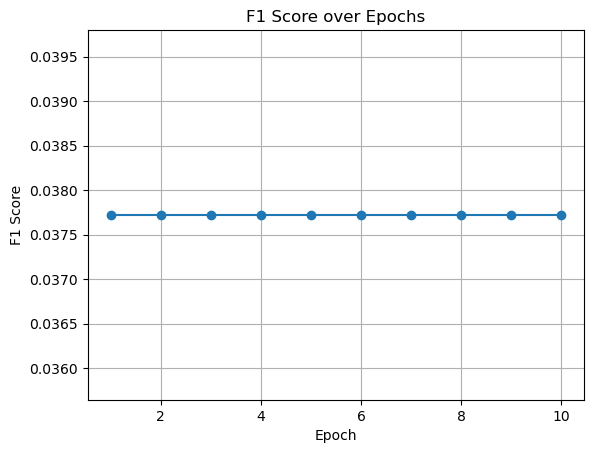

In [80]:
epochs = list(epoch_to_f1.keys())
f1_scores = list(epoch_to_f1.values())

plt.plot(epochs, f1_scores, marker='o', linestyle='-')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

**Вопросы:**
1. Попробуйте также обучить модель без предобученных весов (просто закомментировав загрузку весов). Насколько сильно просело качество?
2. Влияет ли длительность предобучения (количество эпох) как-то существенно на дообучение, или достаточно одной эпохи?

**Ваши ответы напишите здесь:**
1. В моём случае практически ничего не изменилось, что-то не так с finetun'ом...
2. Значение f1-scor'а не меняется от эпохи к эпохе, опять таки из-за проблем с finetun'ом, которые ещё не обнаружил...

## Бонусная часть. Большие модели (максимум 3 балла)

Предлагается обучить модель побольше:
* `hidden_size` $\in \{512, 768, 1024\}$
* `num_hidden_layers` $\in \{8, 12, 24\}$

Например, BERT-base архитектура выглядит как `hidden_size=768, num_hidden_layers=12`.

Для большой модели придется также использовать другие гиперпараметры - нужен learning rate поменьше, weight decay побольше, дропаут больше. Возможно потребуется больше эпох предобучения.

За выполнение этой части можно получить **до пяти бонусных баллов**, бонус зависит от полученных на тесте значений метрики (должно быть видно существенное улучшение).